# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [483]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [484]:
websites = pd.read_csv('../data/website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [485]:
# Getting an idea of the varibales in the dataset
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [486]:
websites["Type"].value_counts()[1]/len(websites)*100

12.128017967434026

In [487]:
# Check the types to see if they are accuratly labled
websites.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

In [488]:
#Checking if datateime is read as object due to missing values
#websites = websites.replace(to_replace="None", value=np.nan)
#websites = websites.dropna(axis=0)
## Conclusion: no

In [489]:
# B/c WHOIS_REGDATE and WHOIS_UPDATED_DATE are objects (and we don't know exactly what type they are) let's convert them to datetime
websites["WHOIS_REGDATE"] = pd.to_datetime(websites["WHOIS_REGDATE"], errors = "coerce")
websites["WHOIS_UPDATED_DATE"] = pd.to_datetime(websites["WHOIS_UPDATED_DATE"], errors = "coerce")

In [490]:
# Though we can see what variables are categorical from the type, here let's use a different method
categorical_var = websites.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64','datetime64']).columns
categorical_var
#When using this method we need to be careful because sometimes categorical variables are written with a correspondance of numbers

Index(['URL', 'CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO',
       'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'],
      dtype='object')

In [491]:
# The colum for what we want to predict is Target (benign = 0 vs malicious=1, this is an assumption based on convention)

In [492]:
#Check unique values in each column
for col in websites.columns:
    print(col, ":", websites[col].unique())

URL : ['M0_109' 'B0_2314' 'B0_911' ... 'B0_162' 'B0_1152' 'B0_676']
URL_LENGTH : [ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 120 122 123 124 125
 126 128 129 131 132 134 135 136 137 139 140 141 142 143 144 145 146 149
 150 151 154 156 160 161 169 170 173 178 183 194 198 201 234 249]
NUMBER_SPECIAL_CHARACTERS : [ 7  6  5  8  9 11 10 13 12 14 15 16 17 18 21 19 20 22 23 28 24 25 36 26
 27 43 30 29 31 34 40]
CHARSET : ['iso-8859-1' 'UTF-8' 'us-ascii' 'ISO-8859-1' 'utf-8' 'None'
 'windows-1251' 'ISO-8859' 'windows-1252']
SERVER : ['nginx' 'Apache/2.4.10' 'Microsoft-HTTPAPI/2.0' 'None' 'Apache/2'
 'nginx/1.10.1' 'Apache' 'Ap

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

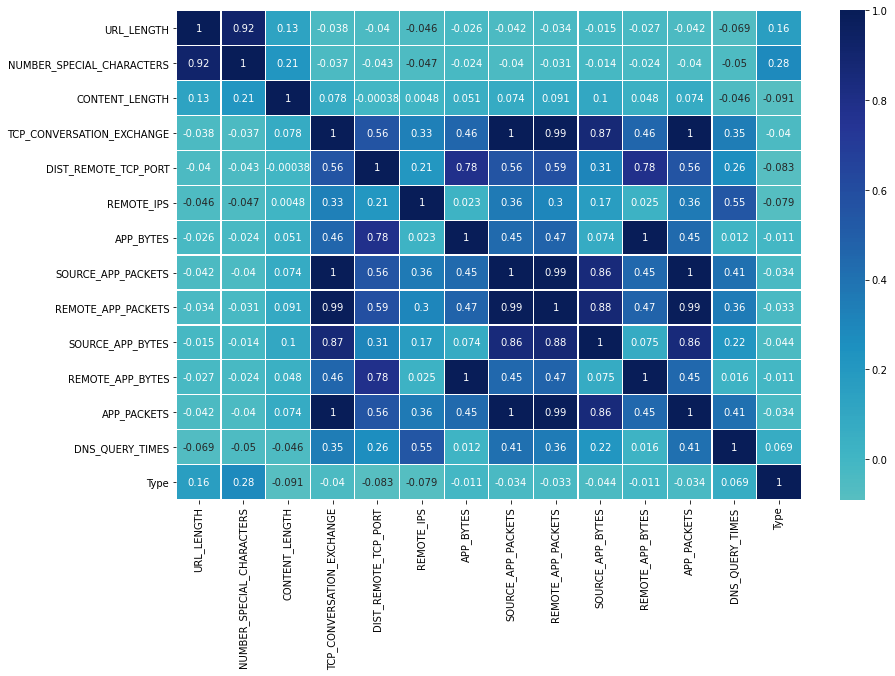

In [493]:
# Create a correlation Dataframe of only numerical values
numeric_columns = websites.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64','object']).corr()
# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(numeric_columns, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 9))

# Draw the heatmap with the mask 
sns.heatmap(numeric_columns, annot=True, cmap = "YlGnBu", center=0,
            linewidths=.2)   #add parameter if want mask -->  mask=mask

In [494]:
#URL_Length and Number_Special_Characters is highly correlated so we should drop one of them
# Also TCP_.. has a high coliniarity with Source_app_Packets, Remote_app_packets, App_packets and source_app_bytes
#If we continue the reasoning column by column and check for correlations in the numbers of 90% we will find other cases of colinearity

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [495]:
#Listing all columns available
numeric_columns.columns

Index(['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CONTENT_LENGTH',
       'TCP_CONVERSATION_EXCHANGE', 'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS',
       'APP_BYTES', 'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS',
       'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES', 'APP_PACKETS',
       'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

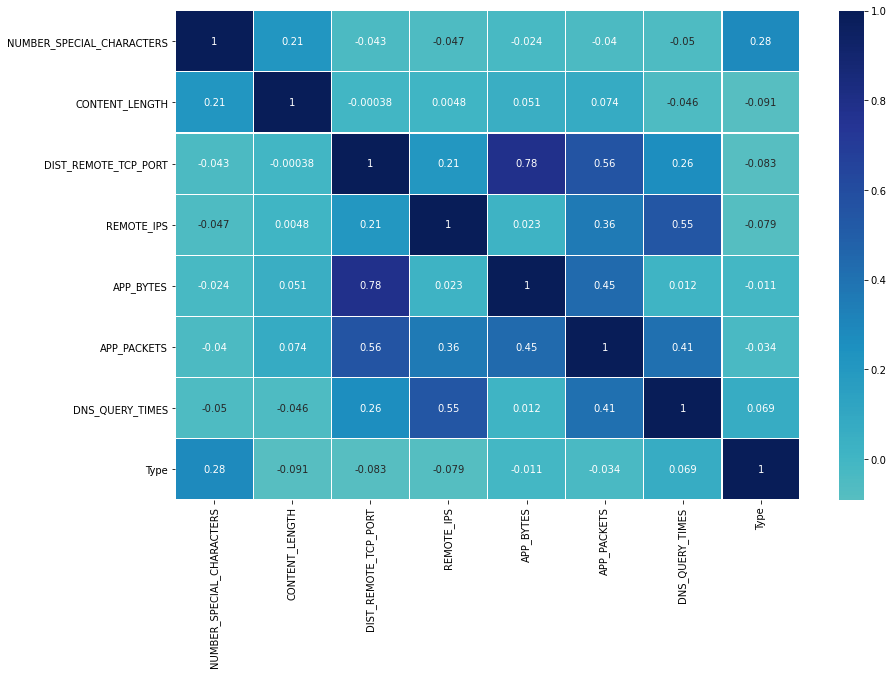

In [496]:
# Removing SOURCE_APP_BYTES   (MAYBE)
# Create a correlation Dataframe of only numerical values
columns_keep = websites.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64','object']).drop(["TCP_CONVERSATION_EXCHANGE","REMOTE_APP_PACKETS","SOURCE_APP_PACKETS","REMOTE_APP_BYTES","URL_LENGTH", "SOURCE_APP_BYTES"], axis =1).corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 9))

# Draw the heatmap with the mask 
sns.heatmap(columns_keep, annot=True, cmap="YlGnBu", center=0,
            linewidths=.2)

In [497]:
#Columns decided to eliminate
drop_colinearity = ["TCP_CONVERSATION_EXCHANGE","REMOTE_APP_PACKETS","SOURCE_APP_PACKETS","REMOTE_APP_BYTES","URL_LENGTH", "SOURCE_APP_BYTES"]

In [498]:
#webstite version no columns
websites_v1 =  websites.drop(drop_colinearity,axis=1)

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [499]:
# Now we want to check how many none/nan/incomplete values, and because we have present more than one of this categories
# I will opt to transform all values of the sort in nan
websites_v1 = websites_v1.replace(to_replace="None", value=np.nan)

In [500]:
websites_v1.isna().sum()

URL                            0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        7
SERVER                       176
CONTENT_LENGTH               812
WHOIS_COUNTRY                306
WHOIS_STATEPRO               362
WHOIS_REGDATE                130
WHOIS_UPDATED_DATE           139
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [501]:
#First lets check the proportion of missing values in the column with more of them
print(websites_v1["CONTENT_LENGTH"].isna().sum()/len(websites_v1)*100)
# High proportion of values in colum missing, so I will opt to drop it
websites_v1.drop("CONTENT_LENGTH", axis=1,inplace=True)

45.59236384053902


In [502]:
#Now lets take a look at WHOIS_STATEPRO
print(websites_v1["WHOIS_STATEPRO"].isna().sum()/len(websites_v1)*100)
# Also a high proportion of values in colum missing, so it might be better to drop the column. In this case b/c I believe
# info on state is more specific than we need and given that we have a column on country, and a categorical value with 
# so much granularity like state won't do us no good I reallly wan't to drpo the STATEPRO column. But before I do it I 
#want to check an intuition, which is to see if the rows with missing values of statepro also have a lot of other missing values.
# If it turns out to be true I will run the model once without those rows while also dropping the column. Though it is risky
#becauseI will loose 20% of my data :(, having a lot of missing values is for me a bad indication of the quality of data for 
#those rows in which the data is missing.
print(len(websites_v1[websites_v1["WHOIS_STATEPRO"].isna() & websites_v1["WHOIS_COUNTRY"].isna()]))
print(len(websites_v1[websites_v1["WHOIS_STATEPRO"].isna() & websites_v1["WHOIS_COUNTRY"].isna() & websites_v1["WHOIS_REGDATE"].isna() & websites_v1["WHOIS_UPDATED_DATE"].isna()]))
# There are 122 rows that contain most of the missing values, so my intuition was right. As such I am goint to make a trial 
#where I drop the rows while also dropping the state column. 
## (option 2)
websites_v1.drop(websites_v1[websites_v1["WHOIS_STATEPRO"].isna() & websites_v1["WHOIS_COUNTRY"].isna() & websites_v1["WHOIS_REGDATE"].isna() & websites_v1["WHOIS_UPDATED_DATE"].isna()].index, inplace = True)
#Moreover, though country column also has a lot of missing values I believe having  a location feture might be important
#for the question at hand (analysis of website) so I'm going to leave it and make a correction which is putt the missing values as other
websites_v1["WHOIS_COUNTRY"] = websites_v1["WHOIS_COUNTRY"].fillna("Other_c")
# Initially I am opting to simply replace the missing values by other though there are a lot, but latter on when I one code the variables
#I will want to run the model with and without the colum of others
#We can't forget that we decided to eliminate the state column so....
websites_v1.drop("WHOIS_STATEPRO", axis=1,inplace=True)

20.325659741718134
306
122


In [503]:
# The next big decision is regarding the columns with time
#for te case in which we didn't drop the rows we have...   (option 1/2)
print(websites_v1["WHOIS_REGDATE"].isna().sum()/len(websites_v1)*100,websites_v1["WHOIS_UPDATED_DATE"].isna().sum()/len(websites_v1)*100)
#...a lot of missing values but not above 10%, next I want to check if the rows in which they are missing are more a less the same
print(len(websites_v1[websites_v1["WHOIS_REGDATE"].isna() & websites_v1["WHOIS_UPDATED_DATE"].isna()]))
# B/c a lot of rows in common I am thinkig of dropping the rows but to do so I want to be sure I won't lose to much information
print(len(websites_v1[websites_v1["WHOIS_REGDATE"].isna() & websites_v1["WHOIS_UPDATED_DATE"].isna()])/len(websites_v1)*100)
#losing 7% of my data is still a bit so to be even more sure on my decision I want to check if these rows are also the
#ones in which the location column has "other" and so it has some uncertanty to it
print(len(websites_v1[websites_v1["WHOIS_REGDATE"].isna() & websites_v1["WHOIS_UPDATED_DATE"].isna() & (websites_v1["WHOIS_COUNTRY"]=="Other")]))
#It seems my intuition is right and given that we have no interest in doing a time series droping the rows(or columns for the matter) 
#is not expected to have a big blow on our prediction
#and I choose to eleminate rows instead of columns because i think there might be some intuition regarding the time between 
#what i assume is website creation date and the update of the same
# Or at least that is what I though until I kept doing the exercise and you said to drop the columns and yes I agree the column
#won't probably matter that much individually (specially now that I understand better what they are) and so I will drop the columns instead of rows
websites_v1.drop(["WHOIS_REGDATE","WHOIS_UPDATED_DATE"], axis=1,inplace=True)
# Moreover, intuitivelly it doen's seem to be a variable that would have a big influence in a site being malicious or not

0.48221820373719104 1.024713682941531
6
0.3616636528028933
0


In [504]:
# Server has a high percentage of missing values and it's high granularity is no interest to our algorithm so I choose ot remove
print(websites_v1["SERVER"].isna().sum()/len(websites_v1)*100)
print(websites_v1["SERVER"].nunique())
#websites_v1.drop("SERVER", axis=1,inplace=True)
#OR that is what I though until I read the rest of the exercise and so I will just put the missing values as other
websites_v1["SERVER"] = websites_v1["SERVER"].fillna("Other_s")

10.30741410488246
230


In [505]:
# The rest of missing data is relatively small and so I will use interpolation to fill numeric values
websites_v1.interpolate(inplace=True)
# and the categorical variable I am felling generous so won't eliminate and instead clasify as others
websites_v1["CHARSET"] = websites_v1["CHARSET"].fillna("Other_c")

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [506]:
websites_v1.isna().sum()

URL                          0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [507]:
websites_v1["WHOIS_COUNTRY"].unique()
websites_v1["WHOIS_COUNTRY"] = websites_v1["WHOIS_COUNTRY"].replace("Cyprus","CY")
websites_v1["WHOIS_COUNTRY"] = websites_v1["WHOIS_COUNTRY"].replace("us","US")
websites_v1["WHOIS_COUNTRY"] = websites_v1["WHOIS_COUNTRY"].replace("se","SE")
websites_v1["WHOIS_COUNTRY"] = websites_v1["WHOIS_COUNTRY"].replace("[u'GB'; u'UK']","GB")
websites_v1["WHOIS_COUNTRY"] = websites_v1["WHOIS_COUNTRY"].replace("United Kingdom","GB")

In [508]:
websites_v1["WHOIS_COUNTRY"].unique()

array(['Other_c', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE',
       'IN', 'LU', 'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'ru',
       'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR',
       'KR', 'HK', 'UA', 'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE',
       'UY', 'KG'], dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

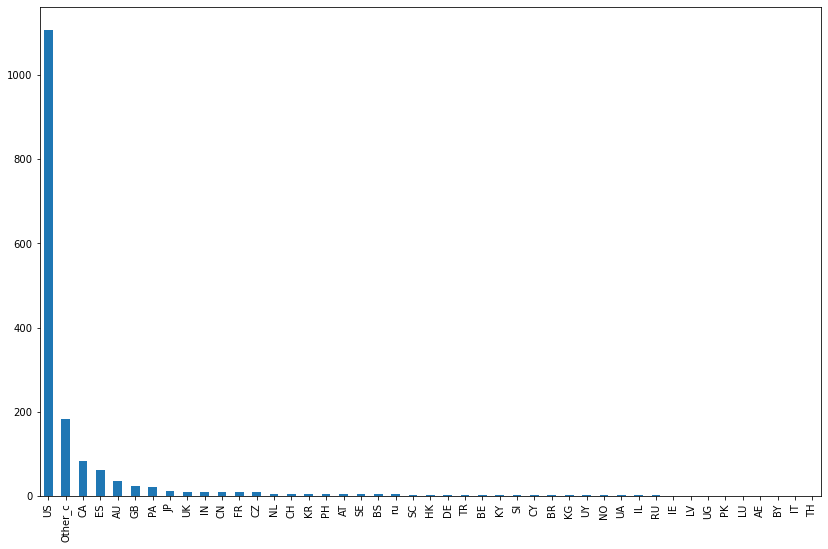

In [509]:
f, ax = plt.subplots(figsize=(14, 9))
websites_v1["WHOIS_COUNTRY"].value_counts().plot(kind='bar')

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [510]:
keep_country = websites_v1["WHOIS_COUNTRY"].value_counts().nlargest(11).index
eliminate_list = set(websites_v1["WHOIS_COUNTRY"].unique()) - set(keep_country) 
for country in eliminate_list:
    websites_v1["WHOIS_COUNTRY"] = websites_v1["WHOIS_COUNTRY"].replace(country,"Other_c")

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [511]:
# I already did, but if I knew you were jsut gona tell us to drop them I wouldn't have spent so much time looking at them :(

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [512]:
websites_v1.dtypes

URL                           object
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
WHOIS_COUNTRY                 object
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [513]:
print(len(websites_v1["URL"].unique()))
websites_v1.drop("URL", axis=1,inplace=True)

1659


#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [514]:
print(len(websites_v1["CHARSET"].unique()))

9


`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [515]:
print(websites["SERVER"].unique())
#(not considering eliminating the column) Maybe grouping all apache together and the same with other like microsoft would be a good option
#But sincirely I don't understand enough of server types to know if this originates clusters of data that aren't of relevance

['nginx' 'Apache/2.4.10' 'Microsoft-HTTPAPI/2.0' 'None' 'Apache/2'
 'nginx/1.10.1' 'Apache' 'Apache/2.2.15 (Red Hat)'
 'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4'
 'openresty/1.11.2.1' 'Apache/2.2.22' 'Apache/2.4.7 (Ubuntu)'
 'nginx/1.12.0'
 'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4'
 'Oracle-iPlanet-Web-Server/7.0' 'cloudflare-nginx' 'nginx/1.6.2'
 'openresty' 'Heptu web server' 'Pepyaka/1.11.3' 'nginx/1.8.0'
 'nginx/1.10.1 + Phusion Passenger 5.0.30' 'Apache/2.2.29 (Amazon)'
 'Microsoft-IIS/7.5' 'LiteSpeed'
 'Apache/2.4.25 (cPanel) OpenSSL/1.0.1e-fips mod_bwlimited/1.4' 'tsa_c'
 'Apache/2.2.0 (Fedora)' 'Apache/2.2.22 (Debian)' 'Apache/2.2.15 (CentOS)'
 'Apache/2.4.25' 'Apache/2.4.25 (Amazon) PHP/7.0.14' 'GSE'
 'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4'
 'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips' 'Apache/2.2.22 (Ubuntu)'
 'Tengine'
 'Apache/2.4.18 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4'
 'Apache/2.4.10 (Debian)' 

In [516]:
from scipy.stats import chi2_contingency
server_y = pd.crosstab(websites['SERVER'], websites['Type'])
server_y_test = chi2_contingency(server_y)
if server_y_test[1]<0.5:
    print("Null hypothesis rejected. They are dependent")
else:
    print("Null hypothesis NOT rejected.")
print("Chi-squared is: ", server_y_test[0])
#B/c droping the column is also I viable option I just wanted to see if there is a big dependency between server and the 
#variable we are trying to predict

Null hypothesis rejected. They are dependent
Chi-squared is:  470.7536003808162


![Think Hard](../images/think-hard.jpg)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [517]:
for row in websites_v1["SERVER"]:
    row = str(row)
    if "Microsoft" in row:
        websites_v1["SERVER"] = websites_v1["SERVER"].replace(row, "Microsoft")
    if "Apache" in str(row):
        websites_v1["SERVER"] = websites_v1["SERVER"].replace(row, "Apache")
    if "nginx" in str(row):
        websites_v1["SERVER"] = websites_v1["SERVER"].replace(row, "nginx")
    else:
        websites_v1["SERVER"] = websites_v1["SERVER"].replace(row, "Other_s")

In [518]:
# Count `SERVER` value counts here
websites_v1["SERVER"].unique()

array(['nginx', 'Other_s', 'Apache', 'Microsoft'], dtype=object)

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [519]:
website_dummy = pd.get_dummies(websites_v1[["SERVER","CHARSET","WHOIS_COUNTRY"]])

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [520]:
website_dummy

,SERVER_Apache,SERVER_Microsoft,SERVER_Other_s,SERVER_nginx,CHARSET_ISO-8859,CHARSET_ISO-8859-1,CHARSET_Other_c,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,...,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_GB,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_Other_c,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1777,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1778,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1779,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [521]:
websites_final = pd.concat([websites_v1,website_dummy], axis=1)
websites_final.drop(["SERVER","CHARSET","WHOIS_COUNTRY"],axis=1,inplace=True)

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [522]:
from sklearn.model_selection import train_test_split
x = websites_final.drop("Type", axis=1, inplace=False)
y = websites_final["Type"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [523]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

--------------------------------------------

In [526]:
# Getting the method
model_1 = LogisticRegression(max_iter=1000)

### Balancing?? (extra) 

**Tradeoff** : this proves to increase recall of malicious websites considerably but reduces precision a lottt 

In [530]:
from sklearn.utils import resample

In [531]:
print(websites_final["Type"].value_counts()[1]/len(websites_final)*100)
print(len(websites_final))
#With the changes made in the meanime, it seems that the data got more imblanced, and so I will try to correct it in order

10.066305003013863
1659


In [533]:
#B/c the dataset is rather small I will opt to upsample the minority group
#Get a data with train X & y together
correct_website = pd.concat([X_train, y_train], axis=1)
# Separate defaults (minority) from no defaults (majority)
bad_website = correct_website[correct_website["Type"]==1]
good_website = correct_website[correct_website["Type"]==0]
# Upsample minority class
upsampled = resample(bad_website, replace=True, n_samples=len(good_website),random_state=0)
# Join together in new dataset
correct_website = pd.concat([good_website, upsampled])
#Assigning back our train variables
X_train = correct_website.drop("Type", axis=1, inplace=False)
y_train = correct_website["Type"]

In [535]:
correct_website["Type"].value_counts()

1    1187
0    1187
Name: Type, dtype: int64

**-->** I'm gona stay here for imbalance correction, but normally my next step would be to check oter method, namely SMOT, however b/c there are 3 ctegorical variables the results might be sub optimal

--------------------------------------------

In [536]:
#the results improved by a couple of decimal places
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [537]:
model_1.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [538]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [539]:
y_pred = model_1.predict(X_test)

In [540]:
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(pd.DataFrame.from_dict(classification_report(y_test,y_pred, output_dict=True)))

0.8373493975903614
[[257  48]
 [  6  21]]
                    0          1  accuracy   macro avg  weighted avg
precision    0.977186   0.304348  0.837349    0.640767      0.922468
recall       0.842623   0.777778  0.837349    0.810200      0.837349
f1-score     0.904930   0.437500  0.837349    0.671215      0.866916
support    305.000000  27.000000  0.837349  332.000000    332.000000


What are your thoughts on the performance of the model? Write your conclusions below.

In [467]:
#Pretty good, but if my objective is making sure I am catching all 
#malicious websites, I might want to improve the model to get a better recall 
#of 1

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [468]:
from sklearn.neighbors import KNeighborsClassifier

In [469]:
model_2 = KNeighborsClassifier(n_neighbors = 3)
model_2 = model_2.fit(X_train, y_train)
y_pred2 = model_2.predict(X_test)

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [470]:
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(pd.DataFrame.from_dict(classification_report(y_test,y_pred2, output_dict=True)))

0.9457831325301205
[[297   8]
 [ 10  17]]
                    0          1  accuracy   macro avg  weighted avg
precision    0.967427   0.680000  0.945783    0.823713      0.944052
recall       0.973770   0.629630  0.945783    0.801700      0.945783
f1-score     0.970588   0.653846  0.945783    0.812217      0.944829
support    305.000000  27.000000  0.945783  332.000000    332.000000


#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [471]:
model_3 = KNeighborsClassifier(n_neighbors = 5)
model_3 = model_3.fit(X_train, y_train)
y_pred3 = model_3.predict(X_test)

In [472]:
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(pd.DataFrame.from_dict(classification_report(y_test,y_pred3, output_dict=True)))

0.9457831325301205
[[299   6]
 [ 12  15]]
                    0          1  accuracy   macro avg  weighted avg
precision    0.961415   0.714286  0.945783    0.837850      0.941317
recall       0.980328   0.555556  0.945783    0.767942      0.945783
f1-score     0.970779   0.625000  0.945783    0.797890      0.942659
support    305.000000  27.000000  0.945783  332.000000    332.000000


Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [419]:
# A little yes

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [420]:
# Your code here